# Fraud Detection

In [2]:
#  importing packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from fancyimpute import KNN
import random
import scikitplot

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit

from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn.linear_model import LogisticRegression

import sklearn.tree as tree
import pydot

from sklearn.decomposition import PCA

from sklearn.externals.six import StringIO 
from IPython.display import Image

from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
random.seed(42)

from sklearn import svm

from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline

pd.set_option('display.float_format', lambda x: '%.3f' % x)

from keras import models
from keras import layers

import imblearn
from imblearn.over_sampling import SMOTE

Using TensorFlow backend.
C:\Users\roder\Anaconda3\lib\site-packages\sklearn\externals\six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)


### Loading Data

In [3]:
df = pd.read_csv('A3 data.csv')

## Initial Inspection

In [4]:
df.head()

step       customer  age gender zipcodeOri       merchant zipMerchant  \
0     0  'C1093826151'  '4'    'M'    '28007'   'M348934600'     '28007'   
1     0   'C352968107'  '2'    'M'    '28007'   'M348934600'     '28007'   
2     0  'C2054744914'  '4'    'F'    '28007'  'M1823072687'     '28007'   
3     0  'C1760612790'  '3'    'M'    '28007'   'M348934600'     '28007'   
4     0   'C757503768'  '5'    'M'    '28007'   'M348934600'     '28007'   

              category  amount  fraud  
0  'es_transportation'   4.550      0  
1  'es_transportation'  39.680      0  
2  'es_transportation'  26.890      0  
3  'es_transportation'  17.250      0  
4  'es_transportation'  35.720      0

There are no NA values

In [5]:
df[df.isna().any(axis=1)]

Empty DataFrame
Columns: [step, customer, age, gender, zipcodeOri, merchant, zipMerchant, category, amount, fraud]
Index: []

Using info shows many columns are using the wrong data types  

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 591746 entries, 0 to 591745
Data columns (total 10 columns):
step           591746 non-null int64
customer       591746 non-null object
age            591746 non-null object
gender         591746 non-null object
zipcodeOri     591746 non-null object
merchant       591746 non-null object
zipMerchant    591746 non-null object
category       591746 non-null object
amount         591746 non-null float64
fraud          591746 non-null int64
dtypes: float64(1), int64(2), object(7)
memory usage: 45.1+ MB


Format of strings includes quotation marks, these need to be removed

In [7]:
print(df['customer'][0])
print(df['age'][0])
print(df['gender'][0])
print(df['zipcodeOri'][0]) 
print(df['merchant'][0])
print(df['zipMerchant'][0])
print(df['category'][0])


'C1093826151'
'4'
'M'
'28007'
'M348934600'
'28007'
'es_transportation'


In [8]:
# replacing values of strings
df['customer'] = df['customer'].str.replace("'", "")
df['age'] = df['age'].str.replace("'", "")
df['gender'] = df['gender'].str.replace("'", "")
df['zipcodeOri'] = df['zipcodeOri'].str.replace("'", "")
df['merchant'] = df['merchant'].str.replace("'", "")
df['zipMerchant'] = df['zipMerchant'].str.replace("'", "")
df['category'] = df['category'].str.replace("'", "")


In [9]:
print(df['customer'][0])
print(df['age'][0])
print(df['gender'][0])
print(df['zipcodeOri'][0])
print(df['merchant'][0])
print(df['zipMerchant'][0])
print(df['category'][0])

C1093826151
4
M
28007
M348934600
28007
es_transportation


The "Age" column appears to be discrete and likely ordinal. The values are likely to be age brackets.  
The "Age" column cannot be converted to integer type until the "U" value is dealt with.

In [10]:
df['age'].value_counts()

2    186390
3    146429
4    108488
5     62328
1     57849
6     26648
0      2441
U      1173
Name: age, dtype: int64

Similarly the Gender column contains "E" and "U" values which need to be resolved

In [11]:
df['gender'].value_counts()

F    322988
M    267072
E      1173
U       513
Name: gender, dtype: int64

There are 1173 rows with age as "U" and gender as "E". This is the same as the total number of rows containing "U" for age and "E" for gender, which means that a "U" in age implies an "E" in gender, and an "E" in gender implies a "U" in age. This leads to the assumption that a gender of "E" signifies a customer that does not fit an age category, so may be an "Entity" or "Enterprise"

In [12]:
len(df['customer'][(df['age']=="U") & (df['gender']=="E")])

1173

The 9 customers which make up the "E" for gender and "U" for age should be checked with the data provider to verify this theory

In [13]:
len(df['customer'][(df['age']=="U") & (df['gender']=="E")].unique())

9

In [14]:
no_gender_age_customers = df['customer'][(df['age'] == "U") & (df['gender'] == "E")].tolist()

In [15]:
df[df['customer'].isin(no_gender_age_customers)].head()

step     customer age gender zipcodeOri     merchant zipMerchant  \
467      0  C2075935351   U      E      28007  M1823072687       28007   
1493     0   C914000857   U      E      28007   M348934600       28007   
1855     0   C808326652   U      E      28007   M348934600       28007   
2091     0  C1374607221   U      E      28007  M1823072687       28007   
2795     1  C1871125244   U      E      28007   M547558035       28007   

               category  amount  fraud  
467   es_transportation  21.250      0  
1493  es_transportation  35.590      0  
1855  es_transportation  56.780      0  
2091  es_transportation  17.470      0  
2795         es_fashion  40.380      0

In [16]:
len(df[df['customer'].isin(no_gender_age_customers)])

1173

Fortunately these values only comprise 0.2% of the data - therefore an approximate integer mean value can be substituted for the age so as to coerce the age column to an integer column type. Gender "E" will be one-hot encoded later

In [17]:
age_mean = np.mean(df['age'][df['age'] != "U"].astype(int))
# almost exactly 3
print("age mean:", age_mean)
print("closest integer value", int(round(age_mean, 0)))

age mean: 3.006226156630933
closest integer value 3


In [18]:
# replacing with mean
df['age'].loc[df['age'] == 'U'] = int(round(age_mean, 0))

C:\Users\roder\Anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


Now that "U" has been removed from age, it can be converted to the correct data type

In [19]:
df['age'].dtypes

dtype('O')

In [20]:
df['age'] = df['age'].astype('int')

In [21]:
df['age'].dtypes

dtype('int32')

Now checking the "U" value for gender. "U" is usually a placeholder for "Unknown", and it seems likely that these are customers for which gender is either unknown or who have not identified as male or female

In [22]:
gender_U_customers = df['customer'][df['gender'] == "U"].tolist()

In [23]:
df[df['customer'].isin(gender_U_customers)].head()

step    customer  age gender zipcodeOri     merchant zipMerchant  \
586      0  C885208928    1      U      28007   M348934600       28007   
828      0  C935791733    3      U      28007  M1823072687       28007   
1849     0  C824676284    2      U      28007   M348934600       28007   
4788     1  C935791733    3      U      28007    M85975013       28007   
6010     2  C935791733    3      U      28007  M1053599405       28007   

               category  amount  fraud  
586   es_transportation  28.570      0  
828   es_transportation  33.120      0  
1849  es_transportation  48.720      0  
4788            es_food  62.870      0  
6010          es_health   9.650      0

In [24]:
df['gender'][df['customer'].isin(gender_U_customers)].value_counts()

U    513
Name: gender, dtype: int64

There are only 3 customers who make up the 513 observations of data with no age information

In [25]:
len(df['customer'][df['customer'].isin(gender_U_customers)].unique())

3

The proportion of observations containing no gender information is extremely small and is not likely to impact any models strongly

In [26]:
print("Proportion of data made up by customers with no gender information:", round(df['gender'][df['customer'].isin(gender_U_customers)].value_counts()[0]/len(df), 3))

Proportion of data made up by customers with no gender information: 0.001


We can one hot encode these columns into Male, Female and Entity. There is no need to include the "other" category since the absence the other 3 values implies the fourth

In [27]:
# making new columns
df['male'] = df['gender'].apply(lambda x: 1 if x == "M" else 0)
df['female'] = df['gender'].apply(lambda x: 1 if x == "F" else 0)
df['entity'] = df['gender'].apply(lambda x: 1 if x == "E" else 0)

# no longer need the gender column
df = df.drop('gender', axis=1)

The gender column has now been converted to the correct datatype

Checking zipMerchant and zipcodeOri reveals that they are all the same value for each row. These columns provide no information and therefore should be removed

In [28]:
df['zipMerchant'].value_counts()

28007    591746
Name: zipMerchant, dtype: int64

In [29]:
df['zipcodeOri'].value_counts()

28007    591746
Name: zipcodeOri, dtype: int64

In [30]:
len(df[(df['zipMerchant'] == '28007') & (df['zipcodeOri'] == '28007')])

591746

In [31]:
df.drop(['zipMerchant','zipcodeOri'], axis=1, inplace=True)

The remaining columns are in the correct format

Merchant appears to be the code for the merchant to which the transaction was made

In [32]:
df['merchant'].value_counts()

M1823072687    298730
M348934600     203953
M85975013       26181
M1053599405      6796
M151143676       6334
M855959430       6043
M1946091778      5317
M1913465890      3983
M209847108       3786
M480139044       3480
M349281107       2871
M1600850729      2607
M1535107174      1843
M980657600       1762
M78078399        1598
M1198415165      1565
M840466850       1390
M1649169323      1167
M547558035        934
M50039827         908
M1888755466       903
M692898500        897
M1400236507       774
M1842530320       743
M732195782        602
M97925176         597
M45060432         571
M1741626453       524
M1872033263       524
M1313686961       523
M1352454843       367
M677738360        358
M2122776122       341
M923029380        323
M3697346          306
M17379832         280
M1748431652       270
M1873032707       250
M2011752106       241
M1416436880       219
M1294758098       189
M1788569036       181
M857378720        122
M348875670        105
M1353266412        78
M933210764

Step is likely to be the index of the transaction of each customer. Step 50 for a customer A will be the 50th recorded transaction of customer A.

In [33]:
df[df['customer'] == 'C2054744914']['step']

2           0
3878        1
5997        2
8902        3
10988       4
14739       5
15065       6
19903       7
22185       8
24442       9
26427      10
29249      11
31229      12
33544      13
36493      14
38805      15
38806      15
42769      16
46032      17
47612      18
51051      19
54871      20
56822      21
59684      22
62520      23
64032      24
68312      25
71444      26
71445      26
73068      28
         ... 
89182      33
90420      34
92359      35
96324      36
98779      37
101735     38
106025     39
108122     40
112364     41
114672     42
118946     43
120839     44
124847     45
126678     46
131015     47
135806     49
140043     50
142335     51
146792     52
149503     53
152574     54
153932     55
199589     69
202426     70
210150     72
351382    114
481065    150
481066    150
549501    168
549502    168
Name: step, Length: 64, dtype: int64

In [34]:
df['step'].value_counts()

175    3774
177    3758
152    3746
174    3743
178    3743
173    3739
172    3728
151    3725
176    3721
169    3721
150    3718
162    3716
171    3716
170    3715
156    3713
158    3711
179    3709
163    3708
165    3707
167    3701
168    3700
166    3693
138    3693
155    3691
159    3688
144    3682
164    3680
149    3680
161    3677
154    3670
       ... 
30     2895
26     2886
29     2883
28     2878
25     2859
24     2806
23     2797
22     2797
21     2789
20     2761
18     2758
19     2734
14     2723
17     2709
15     2699
16     2688
13     2682
12     2671
9      2638
11     2636
10     2622
6      2580
8      2575
7      2539
4      2532
5      2525
3      2499
2      2462
0      2430
1      2424
Name: step, Length: 179, dtype: int64

### EDA

Can see many categories

In [35]:
df['category'].value_counts()

es_transportation        502683
es_food                   26181
es_health                 16064
es_wellnessandbeauty      14976
es_fashion                 6412
es_barsandrestaurants      6334
es_hyper                   6043
es_sportsandtoys           3983
es_tech                    2352
es_home                    1983
es_hotelservices           1734
es_otherservices            903
es_contents                 881
es_travel                   722
es_leisure                  495
Name: category, dtype: int64

How do categoriees affect fraud

In [36]:
fraud_dataframe_counts = pd.DataFrame(data={'names':df['category'][df['fraud'] == 1].value_counts().index.tolist(), 'values':df['category'][df['fraud'] == 1].value_counts().tolist()})
non_fraud_dataframe_counts = pd.DataFrame(data={'names':df['category'][df['fraud'] == 0].value_counts().index.tolist(), 'values':df['category'][df['fraud'] == 0].value_counts().tolist()})

Fraud category counts

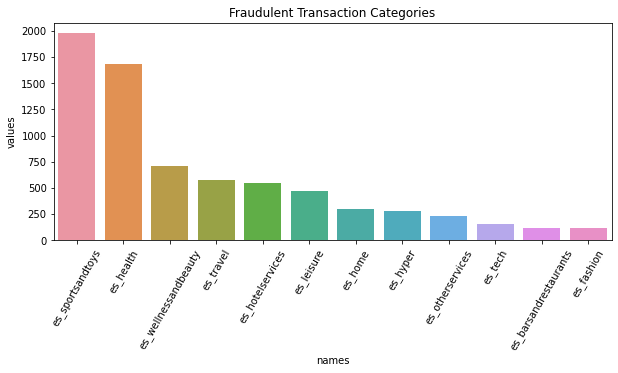

In [37]:
fig = plt.figure(figsize=(10,4))
sns.barplot(x=fraud_dataframe_counts['names'], y=fraud_dataframe_counts['values']);
plt.xticks(rotation=60);
plt.title('Fraudulent Transaction Categories');

Non-Fraud Category Counts

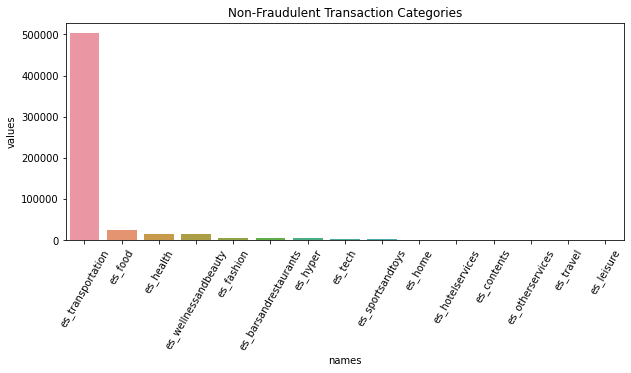

In [38]:
fig = plt.figure(figsize=(10,4))
sns.barplot(x=non_fraud_dataframe_counts['names'], y=non_fraud_dataframe_counts['values']);
plt.xticks(rotation=60);
plt.title('Non-Fraudulent Transaction Categories');

How does value correspond to fraud

In [39]:
# make fraud and non fraud dataframe
df_fraud = df[df['fraud'] == 1]
df_nonfraud = df[df['fraud'] == 0]

Frauds are higher on average but very rarely above 1000, beyond 1000 the likelihood appears approximately equal  
Perhaps frauds don't want to push their luck

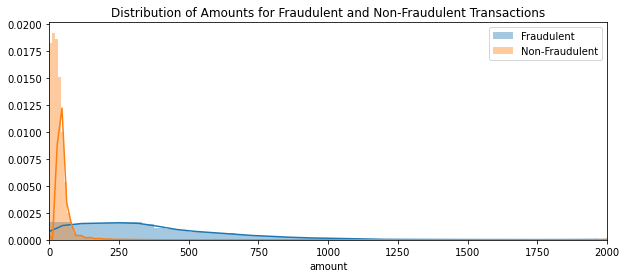

In [40]:
fig = plt.figure(figsize=(10,4))
ax = plt.axes()
ax.set_xlim(right=2000)
sns.distplot(df_fraud['amount'], bins=200);
sns.distplot(df_nonfraud['amount'], bins=200);
ax.legend(["Fraudulent", "Non-Fraudulent"]);
plt.title('Distribution of Amounts for Fraudulent and Non-Fraudulent Transactions');

How does category affect value in fraud and non fraud  
Travel is the highest spend, no significant visible deviance from the distribution of nonfraud

In [41]:
category_list = df['category'].unique().tolist()
category_list = sorted(category_list)

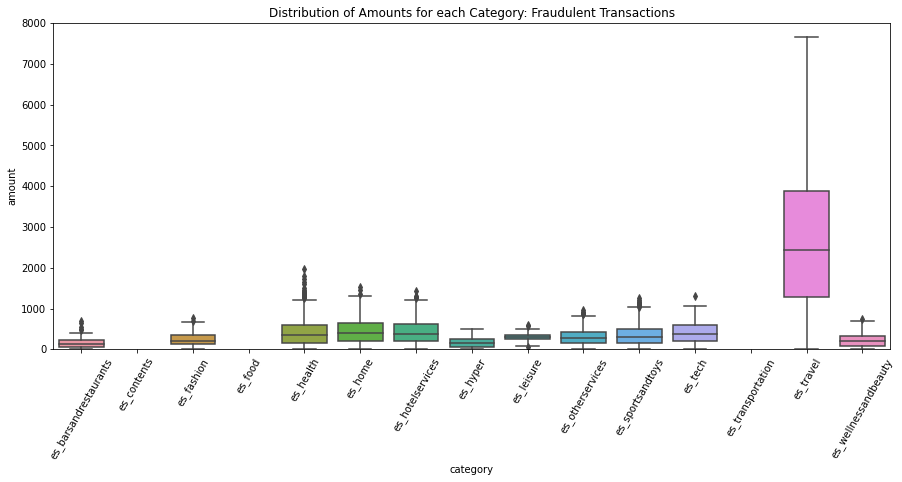

In [42]:
fig = plt.figure(figsize=(15,6))
ax = plt.axes()
ax.set_ylim(top=8000)
sns.boxplot(x=df_fraud['category'], y=df_fraud['amount'], order=category_list);
plt.xticks(rotation=60);
plt.title('Distribution of Amounts for each Category: Fraudulent Transactions');

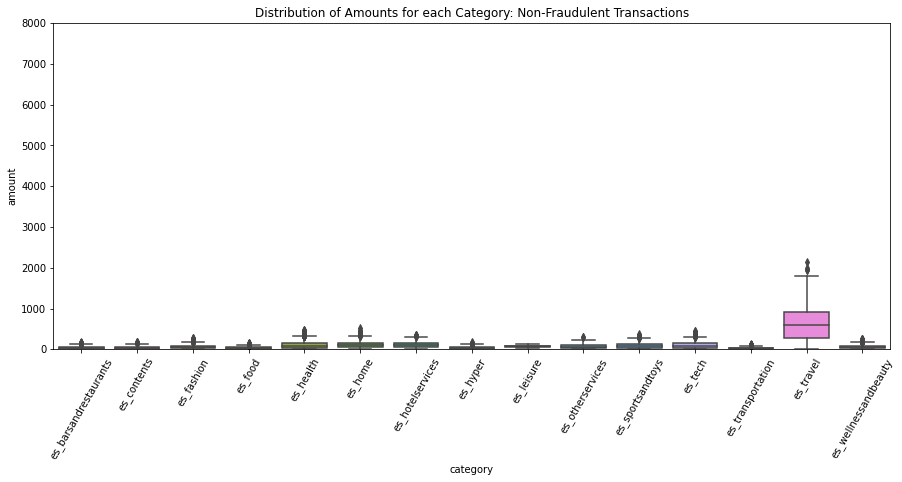

In [43]:
fig = plt.figure(figsize=(15,6))
ax = plt.axes()
ax.set_ylim(top=8000)
sns.boxplot(x=df_nonfraud['category'], y=df_nonfraud['amount'], order=category_list);
plt.xticks(rotation=60);
plt.title('Distribution of Amounts for each Category: Non-Fraudulent Transactions');

How does merchant affect value in fraud and non fraud  
Plotting fraud and non fraud values across mechants on same scale  
The interactions are difficult to see, it is at least clear that there are examples of non-fraudulent activity for every merchant, which reduces the likelihood that a machine learning model would overfit on a merchant and learn to classify one as always fraud.  
The reverse is not true, but this could be a fact of fraudulent transactions, that they very rarely or never exist on some merchants.

In [44]:
merchant_list = df['merchant'].unique().tolist()
merchant_list = sorted(merchant_list)

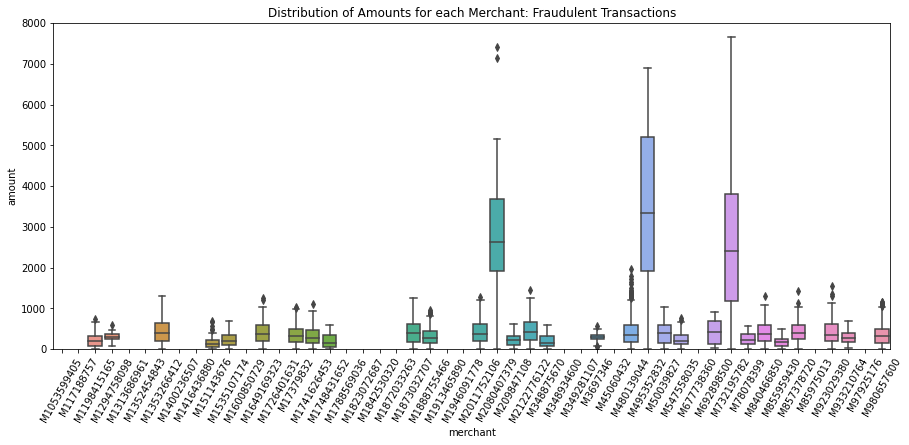

In [45]:
fig = plt.figure(figsize=(15,6))
ax = plt.axes()
ax.set_ylim(top=8000)
sns.boxplot(x=df_fraud['merchant'], y=df_fraud['amount'], order=merchant_list);
plt.xticks(rotation=60);
plt.title('Distribution of Amounts for each Merchant: Fraudulent Transactions');

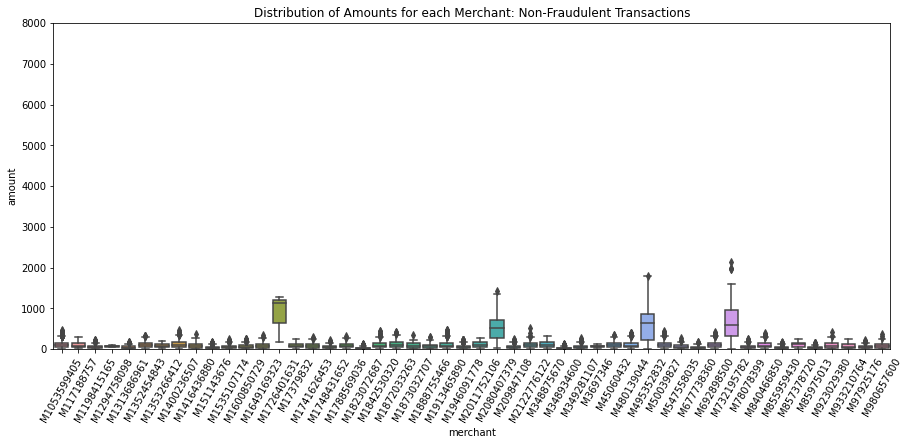

In [46]:
fig = plt.figure(figsize=(15,6))
ax = plt.axes()
ax.set_ylim(top=8000)
sns.boxplot(x=df_nonfraud['merchant'], y=df_nonfraud['amount'], order=merchant_list);
plt.xticks(rotation=60);
plt.title('Distribution of Amounts for each Merchant: Non-Fraudulent Transactions');

### Dropping Redundant Columns

Fixing some variables

In [48]:
df['age'].value_counts()

2    186390
3    147602
4    108488
5     62328
1     57849
6     26648
0      2441
Name: age, dtype: int64

In [49]:
median_age = int(np.median(df['age'][df['age'] != "U"].astype('int')))

C:\Users\roder\Anaconda3\lib\site-packages\pandas\core\ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


In [50]:
df.loc[df['age'] == "U", 'age'] = str(median_age)

In [51]:
df['age'].value_counts().index

Int64Index([2, 3, 4, 5, 1, 6, 0], dtype='int64')

In [52]:
df['age'] = df['age'].astype(int)

In [53]:
df['age'].value_counts()

2    186390
3    147602
4    108488
5     62328
1     57849
6     26648
0      2441
Name: age, dtype: int64

### Preprocessing for Machine Learning Models

Initially converting the category columns in a suboptimal way - label encoding

In [54]:
LE = LabelEncoder()
df_processed = df.copy()
df_processed['merchant_code'] = LE.fit_transform(df_processed['merchant'])
df_processed['category_code'] = LE.fit_transform(df_processed['category'])

df_processed.drop(['merchant', 'category'], axis=1, inplace=True)


Also removing the "customer" variable which is unlikely to add anything  
Not only that, but it doesn't make sense to train a model based on experiences with specific customer accounts. The model should be able to generalise to all customers

In [55]:
df_processed.drop('customer', axis=1, inplace=True)

In [56]:
df_processed.head()

step  age  amount  fraud  male  female  entity  merchant_code  \
0     0    4   4.550      0     1       0       0             30   
1     0    2  39.680      0     1       0       0             30   
2     0    4  26.890      0     0       1       0             18   
3     0    3  17.250      0     1       0       0             30   
4     0    5  35.720      0     1       0       0             30   

   category_code  
0             12  
1             12  
2             12  
3             12  
4             12

In [57]:
df_processed.columns

Index(['step', 'age', 'amount', 'fraud', 'male', 'female', 'entity',
       'merchant_code', 'category_code'],
      dtype='object')

### Making PCA dataframe

In [58]:
x_pca = df_processed.drop('fraud', axis=1).values

y_pca = df_processed['fraud'].values
# Standardizing the features
x_pca = StandardScaler().fit_transform(x_pca)

In [59]:
pca_1 = PCA(n_components=2)
principalComponents = pca_1.fit_transform(x_pca)
principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])

In [60]:
pca_1.explained_variance_ratio_

array([0.24952704, 0.16516261])

In [61]:
df_pca = pd.concat([principalDf, df_processed[['fraud']]], axis = 1)

In [62]:
df_pca.head()

principal component 1  principal component 2  fraud
0                 -1.576                  0.790      0
1                 -1.517                  0.889      0
2                  1.244                 -0.157      0
3                 -1.548                  0.825      0
4                 -1.597                  0.883      0

In 2 dimensions we can't see clear clusters

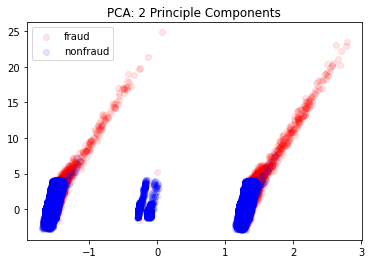

In [63]:
plt.scatter(x=df_pca['principal component 1'][df_pca['fraud']==1], y=df_pca['principal component 2'][df_pca['fraud']==1], c='red', alpha=0.1);
plt.scatter(x=df_pca['principal component 1'][df_pca['fraud']==0], y=df_pca['principal component 2'][df_pca['fraud']==0], c='blue', alpha=0.1);
plt.legend(['fraud', 'nonfraud']);
plt.title('PCA: 2 Principle Components');

In [64]:
pca_2 = PCA(n_components=3)
principalComponents_2 = pca_2.fit_transform(x_pca)
principalDf_2 = pd.DataFrame(data = principalComponents_2, columns = ['pc_1', 'pc_2','pc_3'])

In [65]:
pca_2.explained_variance_ratio_

array([0.24952704, 0.16516261, 0.12990119])

Redefining df_pca with more components

In [66]:
df_pca = pd.concat([principalDf_2, df[['fraud']]], axis = 1)

Even in 3 dimensions we can't see a clear clusters

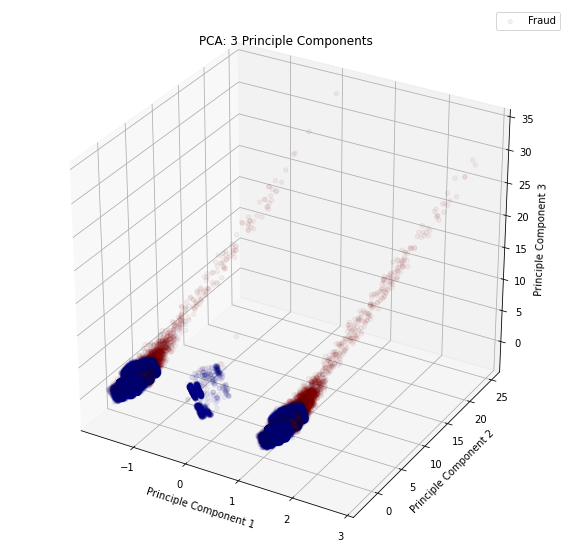

In [67]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(df_pca['pc_1'],df_pca['pc_2'],df_pca['pc_3'],c=df_pca['fraud'], cmap=plt.get_cmap("jet"), alpha=0.05);
ax.set_xlabel('Principle Component 1');
ax.set_ylabel('Principle Component 2');
ax.set_zlabel('Principle Component 3');
plt.title('PCA: 3 Principle Components');
plt.legend(['Fraud', 'Nonfraud']);

To get a good variance explained it really requires about 5 principle components. There are already 8 featues so a reduction of 3 isn't worth the loss in variance explained.  
It seems these relationships are not linearly seperable, and a non-linear solution should be attempted

In [68]:
pca_3 = PCA(n_components=5)
principalComponents_3 = pca_3.fit_transform(x_pca)
round(sum(pca_3.explained_variance_ratio_), 3)

0.795

Conclusion - PCA will not do a good job of extracting features, also not good for visualisation since variability explained by 2 or even 3 features is so low, and clusters are not visible

### Train Test  Split

Prior to oversampling, it is necessary to split the train and test data, oversampling must only be performed on the training data, so as to not contaminate the traniing data with actual test values - this would invalidate the model    
It is important that each of the train and test data contains the same proportion of fraudulent transactions, to ensure that any machine learning model will be able to learn and be tested effectively, so this will use a stratified sample

In [69]:
X = df_processed.drop('fraud',axis=1)
y = df_processed['fraud']

folds = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in folds.split(df_processed, df_processed['fraud']):
    X_strat_train_set, X_strat_test_set = X.loc[train_index], X.loc[test_index]
    y_strat_train_set, y_strat_test_set = y.loc[train_index], y.loc[test_index]
    
print("number of transactions in training data:", len(y_strat_train_set))
print("number of transactions in testing data:", len(y_strat_test_set))    
    
print("number of fraudulent transacitons in training data:", len(y_strat_train_set[y_strat_train_set == 1]))
print("number of fraudulent transacitons in testing data:", len(y_strat_test_set[y_strat_test_set == 1]))
    
print("proportion of fraudulent transacitons in training data:", round(len(y_strat_train_set[y_strat_train_set == 1])/len(y_strat_train_set), 3))
print("proportion of fraudulent transacitons in testing data:", round(len(y_strat_test_set[y_strat_test_set == 1])/len(y_strat_test_set), 3))
    


X_pca = df_pca.drop('fraud',axis=1)
y_pca = df_pca['fraud']

folds = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in folds.split(df_pca, df_pca['fraud']):
    X_strat_train_set_pca, X_strat_test_set_pca = X_pca.loc[train_index], X_pca.loc[test_index]
    y_strat_train_set_pca, y_strat_test_set_pca = y_pca.loc[train_index], y_pca.loc[test_index]
    
print("number of transactions in PCA training data:", len(y_strat_train_set_pca))
print("number of transactions in PCA testing data:", len(y_strat_test_set_pca))    
    
print("number of fraudulent transacitons in PCA training data:", len(y_strat_train_set_pca[y_strat_train_set_pca == 1]))
print("number of fraudulent transacitons in PCA testing data:", len(y_strat_test_set_pca[y_strat_test_set_pca == 1]))
    
print("proportion of fraudulent transacitons in PCA training data:", round(len(y_strat_train_set_pca[y_strat_train_set_pca == 1])/len(y_strat_train_set_pca), 3))
print("proportion of fraudulent transacitons in PCA testing data:", round(len(y_strat_test_set_pca[y_strat_test_set_pca == 1])/len(y_strat_test_set_pca), 3))
    



number of transactions in training data: 473396
number of transactions in testing data: 118350
number of fraulent transacitons in training data: 5728
number of fraulent transacitons in testing data: 1432
proportion of fraulent transacitons in training data: 0.012
proportion of fraulent transacitons in testing data: 0.012
number of transactions in PCA training data: 473396
number of transactions in PCA testing data: 118350
number of fraulent transacitons in PCA training data: 5728
number of fraulent transacitons in PCA testing data: 1432
proportion of fraulent transacitons in PCA training data: 0.012
proportion of fraulent transacitons in PCA testing data: 0.012


Used the same random state, so should have the same train and test split for pca and non-pca data. The indices for train and test should be the same

In [70]:
df_pca.index

RangeIndex(start=0, stop=591746, step=1)

### Oversampling

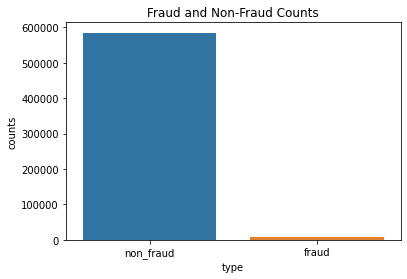

In [71]:
fraud_counts = pd.DataFrame(data = {'type':['non_fraud', 'fraud'], 'counts': df_processed['fraud'].value_counts().tolist()})
sns.barplot(x=fraud_counts['type'], y=fraud_counts['counts']);
plt.title('Fraud and Non-Fraud Counts');

In [72]:
print("ratio of fraud to non-fraud:", round(df_processed['fraud'].value_counts()[1]/df_processed['fraud'].value_counts()[0], 3), ": 1.0")

ratio of fraud to non-fraud: 0.012 : 1.0


Defining a function to oversample

In [73]:
print("length of the original dataframe", len(df_processed))
print("number of non fraudulent transactions", len(df_processed[df_processed['fraud'] == 0]))
print("number of fraudulent transactions", len(df_processed[df_processed['fraud'] == 1]))

length of the original dataframe 591746
number of non fraudulent transactions 584586
number of fraudulent transactions 7160


The oversamping should only be used on training data

In [74]:
# function resamples fraudulent transactions with replacement and returns a balanced dataframe

def oversample_fraud(X_train, y_train):
    dataframe = pd.concat([X_train, y_train], axis=1)
    fraud_indices = dataframe[dataframe['fraud'] == 1].index.tolist()
    non_fraud_length = len(dataframe[dataframe['fraud'] == 0])
    resampled_indices = np.random.choice(fraud_indices, size=non_fraud_length, replace = True)
    resampled_rows = dataframe.loc[resampled_indices,:]
    new_dataframe = pd.concat([dataframe[dataframe['fraud'] == 0], resampled_rows])
    new_dataframe = new_dataframe.sample(frac=1).reset_index(drop=True)
    return(new_dataframe, new_dataframe.drop('fraud', axis=1), new_dataframe['fraud'])
    

oversampled_df, X_train, y_train = oversample_fraud(X_strat_train_set, y_strat_train_set)
print("length of oversampled training data", len(oversampled_df))
X_test = X_strat_test_set.copy()
y_test = y_strat_test_set.copy()


oversampled_df_pca, X_train_pca, y_train_pca = oversample_fraud(X_strat_train_set_pca, y_strat_train_set_pca)
print("length of oversampled training data from PCA dataframe", len(oversampled_df_pca))
X_test_pca = X_strat_test_set_pca.copy()
y_test_pca = y_strat_test_set_pca.copy()

length of oversampled training data 935336
length of oversampled training data from PCA dataframe 935336


Now the training data (and the training data for the PCA dataframe) contains an equal number of fraudulent and non fraudulent transactions

In [75]:
y_train.value_counts()

1    467668
0    467668
Name: fraud, dtype: int64

In [76]:
y_train_pca.value_counts()

1    467668
0    467668
Name: fraud, dtype: int64

We can visualise this as before with a bar chart

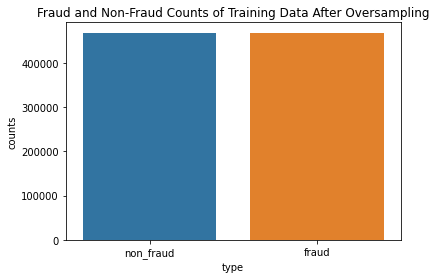

In [77]:
fraud_counts = pd.DataFrame(data = {'type':['non_fraud', 'fraud'], 'counts': y_train.value_counts().tolist()})
sns.barplot(x=fraud_counts['type'], y=fraud_counts['counts']);
plt.title('Fraud and Non-Fraud Counts of Training Data After Oversampling');

In [78]:
print("ratio of fraud to non-fraud:", round(y_train.value_counts()[1]/y_train.value_counts()[0], 3), ": 1.0")

ratio of fraud to non-fraud: 1.0 : 1.0


To summarise, the training data for pca and non-pca dataframes have been oversampled to create an equal number of fraudulent and non-fraudulent observations

In [81]:
print(len(X_train))
print(len(y_train))
print(len(X_test))
print(len(y_test))

935336
935336
118350
118350


### Modelling

Note that y_test is largely made up of non-fraud, 81.6%. Any good model needs to be significantly higher than 81.6%, as guessing non-fraud every time without any model would result in 81.6% accuracy

The models have been trained on artificially balanced data, which should mean that the model should not have learned to overpredict on one class, although it may suffer from overfitting as there is a great deal of repeated data.  
The accuracy is high, and this is largely because the model is very good at correctly identifying negatives, but the main focus of the task is to correctly identify fraudulent transactions.  
Therefore the sensitivity is more important than specificity or even accuracy  

**Random Forest**

In [82]:
def run_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
#     print(model.score(X_test,y_test))
    y_predicted = model.predict(X_test)
    cmx = confusion_matrix(y_predicted, y_test)

    TN = cmx[0,0]
    FN = cmx[0,1]
    FP = cmx[1,0]
    TP = cmx[1,1]

    accuracy = (TN + TP)/(TN + FN + FP + TP)
    sensitivity = (TP)/(TP + FP)
    specificity = (TN)/(TN + FN)
    
    print("True Negatives:", TN)
    print("False Negatives:", FN)
    print("False Positives:", FP)
    print("True Positives:", TP)

    print("Accuracy:", (TN + TP)/(TN + FN + FP + TP))
    print("Sensitivity:", (TP)/(TP + FP))
    print("Specificity:", (TN)/(TN + FN))

    sns.heatmap(cmx, annot=True);
    plt.xlabel('predicted');
    plt.ylabel('truth');
    plt.title("Model: " + str(model.__class__.__name__));
    return(accuracy, sensitivity, specificity, model);

**Decision tree**

In [83]:
X_train.columns

Index(['step', 'age', 'amount', 'male', 'female', 'entity', 'merchant_code',
       'category_code'],
      dtype='object')

True Negatives: 116640
False Negatives: 387
False Positives: 278
True Positives: 1045
Accuracy: 0.9943810730882974
Sensitivity: 0.7898715041572184
Specificity: 0.9966930708298085


(0.9943810730882974,
 0.7898715041572184,
 0.9966930708298085,
 DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                        max_depth=None, max_features=None, max_leaf_nodes=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, presort='deprecated',
                        random_state=None, splitter='best'))

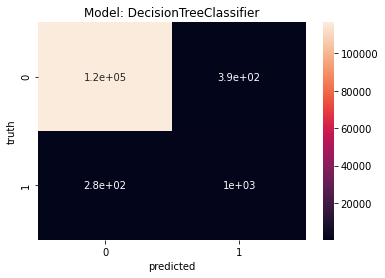

In [84]:
run_model(model = tree.DecisionTreeClassifier(criterion = "entropy"), X_train = X_train, y_train=y_train, X_test=X_test, y_test=y_test)

Random Forest

True Negatives: 116716
False Negatives: 349
False Positives: 202
True Positives: 1083
Accuracy: 0.9953443177017322
Sensitivity: 0.8428015564202335
Specificity: 0.9970187502669458


(0.9953443177017322,
 0.8428015564202335,
 0.9970187502669458,
 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                        criterion='gini', max_depth=None, max_features='auto',
                        max_leaf_nodes=None, max_samples=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, n_estimators=20,
                        n_jobs=None, oob_score=False, random_state=None,
                        verbose=0, warm_start=False))

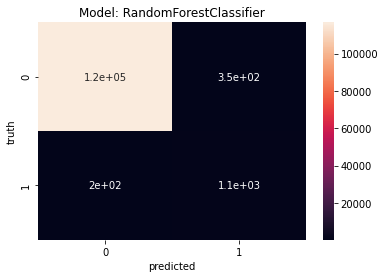

In [85]:
run_model(model = RandomForestClassifier(n_estimators=20), X_train = X_train, y_train=y_train, X_test=X_test, y_test=y_test)

Some models require scaling

In [86]:
X_train_scaled = StandardScaler().fit_transform(X_train.drop(['male', 'female', 'age','step'], axis=1))
X_test_scaled = StandardScaler().fit_transform(X_test.drop(['male', 'female', 'age', 'step'], axis=1))

# pca_data is already scaled


**SVM**

Note that training this is very slow. This will use only the first 100000 observations as the full dataset would be too computationally expensive

True Negatives: 50018
False Negatives: 110
False Positives: 66900
True Positives: 1322
Accuracy: 0.4337980566117448
Sensitivity: 0.019377913283105157
Specificity: 0.9978056176188956


(0.4337980566117448,
 0.019377913283105157,
 0.9978056176188956,
 SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
     decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
     max_iter=-1, probability=False, random_state=None, shrinking=True,
     tol=0.001, verbose=False))

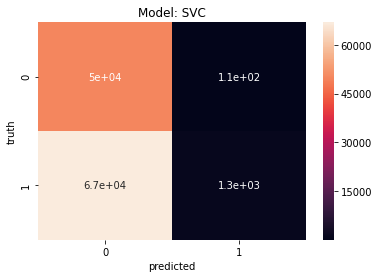

In [87]:
run_model(model = svm.SVC(), X_train = X_train_scaled[0:100000], y_train=y_train[0:100000], X_test=X_test_scaled, y_test=y_test)

**KNN**

True Negatives: 96218
False Negatives: 73
False Positives: 20700
True Positives: 1359
Accuracy: 0.8244782425010562
Sensitivity: 0.06160750713994288
Specificity: 0.999241881380399


(0.8244782425010562,
 0.06160750713994288,
 0.999241881380399,
 KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                      metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                      weights='uniform'))

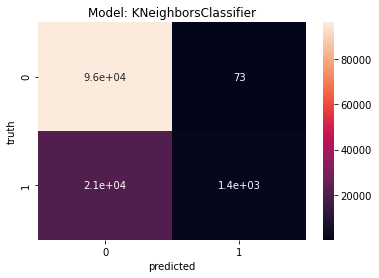

In [88]:
knn_results = run_model(model = KNeighborsClassifier(n_neighbors=5), X_train = X_train_scaled, y_train=y_train, X_test=X_test_scaled, y_test=y_test)
knn_results

In [89]:
y_predicted_knn = knn_results[3].predict(X_test_scaled)

For visualisation purposes, it can be seen that clustering stuggles to classify values far from their usual locations. The visualisation is limited here as only a maximum of 3 dimensions can be displayed

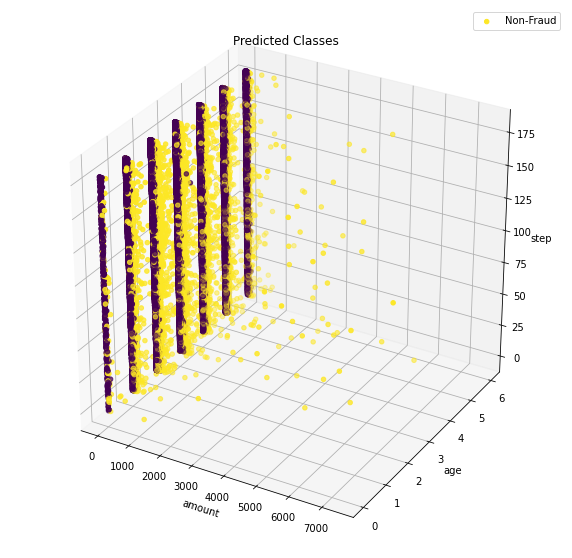

In [90]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X_test['amount'],X_test['age'],X_test['step'],c=y_predicted_knn);
ax.set_xlabel('amount');
ax.set_ylabel('age');
ax.set_zlabel('step');
plt.title('Predicted Classes');
plt.legend(['Non-Fraud', 'fraud']);

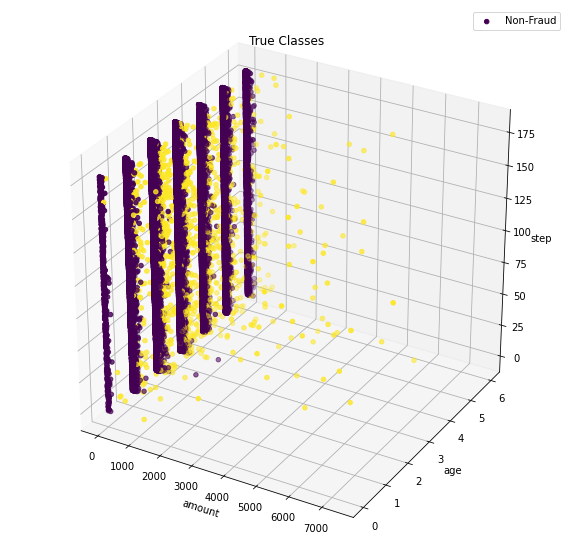

In [91]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X_test['amount'],X_test['age'],X_test['step'],c=y_test);
ax.set_xlabel('amount');
ax.set_ylabel('age');
ax.set_zlabel('step');
plt.title('True Classes');
plt.legend(['Non-Fraud', 'fraud']);

**Neural Network**

Epoch 1/20
935336/935336 [==============================] - 32s 34us/step - loss: 0.0871 - accuracy: 0.9661
Epoch 2/20
935336/935336 [==============================] - 34s 37us/step - loss: 0.0698 - accuracy: 0.9732
Epoch 3/20
935336/935336 [==============================] - 36s 38us/step - loss: 0.0673 - accuracy: 0.9736
Epoch 4/20
935336/935336 [==============================] - 30s 32us/step - loss: 0.0655 - accuracy: 0.9741
Epoch 5/20
935336/935336 [==============================] - 27s 29us/step - loss: 0.0643 - accuracy: 0.9742
Epoch 6/20
935336/935336 [==============================] - 27s 29us/step - loss: 0.0636 - accuracy: 0.9746
Epoch 7/20
935336/935336 [==============================] - 26s 28us/step - loss: 0.0633 - accuracy: 0.9746
Epoch 8/20
935336/935336 [==============================] - 27s 29us/step - loss: 0.0630 - accuracy: 0.9746
Epoch 9/20
935336/935336 [==============================] - 27s 29us/step - loss: 0.0629 - accuracy: 0.9746
Epoch 10/20
935336/935336 [=

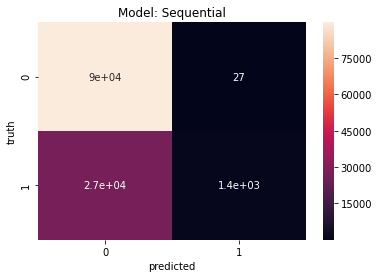

In [167]:
# keras neural network

model = models.Sequential()
model.add(layers.Dense(10, activation='relu', input_shape=(X_train_scaled.shape[1],)))

model.add(layers.Dense(5, activation='relu'))

model.add(layers.Dense(3, activation='relu'))

model.add(layers.Dense(2, activation='softmax'))

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(X_train_scaled,
                    y_train,
                    epochs=20,
                    batch_size=32)

y_predicted_nn = model.predict_classes(X_test_scaled)

cmx = confusion_matrix(y_predicted_nn, y_test)
sns.heatmap(cmx, annot=True)
plt.xlabel('predicted')
plt.ylabel('truth')
plt.title("Model: " + str(model.__class__.__name__));

TN = cmx[0,0]
FN = cmx[0,1]
FP = cmx[1,0]
TP = cmx[1,1]



print("True Negatives:", TN)
print("False Negatives:", FN)
print("False Positives:", FP)
print("True Positives:", TP)

print("Accuracy:", (TN + TP)/(TN + FN + FP + TP))
print("Sensitivity:", (TP)/(TP + FP))
print("Specificity:", (TN)/(TN + FN))

### Modelling on PCA Data

True Negatives: 116306
False Negatives: 838
False Positives: 612
True Positives: 594
Accuracy: 0.9877482044782425
Sensitivity: 0.4925373134328358
Specificity: 0.9928464112545243


(0.9877482044782425,
 0.4925373134328358,
 0.9928464112545243,
 DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                        max_depth=None, max_features=None, max_leaf_nodes=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, presort='deprecated',
                        random_state=None, splitter='best'))

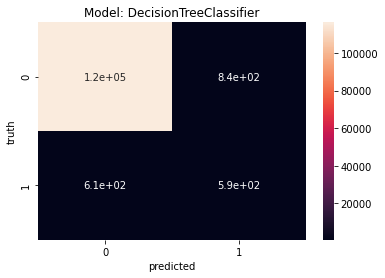

In [93]:
run_model(model = tree.DecisionTreeClassifier(criterion = "entropy"),  X_train = X_train_pca, y_train=y_train_pca, X_test=X_test_pca, y_test=y_test_pca)

True Negatives: 116732
False Negatives: 874
False Positives: 186
True Positives: 558
Accuracy: 0.9910435149978877
Sensitivity: 0.75
Specificity: 0.9925684063738245


(0.9910435149978877,
 0.75,
 0.9925684063738245,
 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                        criterion='gini', max_depth=None, max_features='auto',
                        max_leaf_nodes=None, max_samples=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, n_estimators=20,
                        n_jobs=None, oob_score=False, random_state=None,
                        verbose=0, warm_start=False))

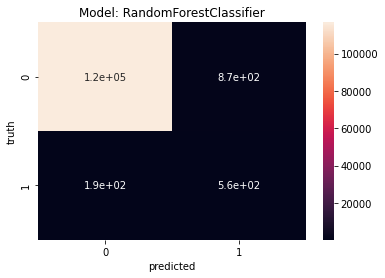

In [94]:
run_model(model = RandomForestClassifier(n_estimators=20),  X_train = X_train_pca, y_train=y_train_pca, X_test=X_test_pca, y_test=y_test_pca)

True Negatives: 114975
False Negatives: 665
False Positives: 1943
True Positives: 767
Accuracy: 0.9779636670891424
Sensitivity: 0.2830258302583026
Specificity: 0.9942493946731235


(0.9779636670891424,
 0.2830258302583026,
 0.9942493946731235,
 KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                      metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                      weights='uniform'))

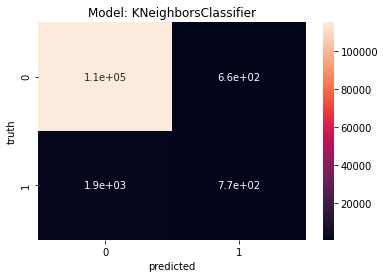

In [95]:
run_model(model = KNeighborsClassifier(n_neighbors=5), X_train = X_train_pca, y_train=y_train_pca, X_test=X_test_pca, y_test=y_test_pca)

Epoch 1/20
935336/935336 [==============================] - 37s 40us/step - loss: 0.2651 - accuracy: 0.9100
Epoch 2/20
935336/935336 [==============================] - 26s 28us/step - loss: 0.2368 - accuracy: 0.9166
Epoch 3/20
935336/935336 [==============================] - 29s 31us/step - loss: 0.2214 - accuracy: 0.9187
Epoch 4/20
935336/935336 [==============================] - 26s 28us/step - loss: 0.2168 - accuracy: 0.9204
Epoch 5/20
935336/935336 [==============================] - 26s 28us/step - loss: 0.2154 - accuracy: 0.9208
Epoch 6/20
935336/935336 [==============================] - 27s 29us/step - loss: 0.2142 - accuracy: 0.9209
Epoch 7/20
935336/935336 [==============================] - 28s 30us/step - loss: 0.2130 - accuracy: 0.9212
Epoch 8/20
935336/935336 [==============================] - 26s 28us/step - loss: 0.2121 - accuracy: 0.9211
Epoch 9/20
935336/935336 [==============================] - 26s 28us/step - loss: 0.2111 - accuracy: 0.9214
Epoch 10/20
935336/935336 [=

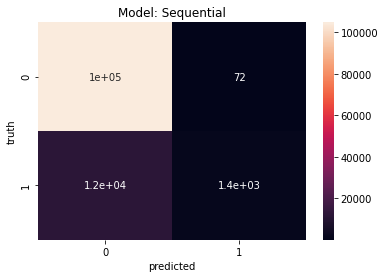

In [161]:
# keras neural network on PCA data
model = models.Sequential()
model.add(layers.Dense(10, activation='relu', input_shape=(X_train_pca.shape[1],)))

model.add(layers.Dense(5, activation='relu'))

model.add(layers.Dense(3, activation='relu'))

model.add(layers.Dense(2, activation='softmax'))

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


history = model.fit(X_train_pca,
                    y_train_pca,
                    epochs=20,
                    batch_size=32)

y_predicted_nn = model.predict_classes(X_test_pca)

cmx = confusion_matrix(y_predicted_nn, y_test_pca)
sns.heatmap(cmx, annot=True)
plt.xlabel('predicted')
plt.ylabel('truth')
plt.title("Model: " + str(model.__class__.__name__));

TN = cmx[0,0]
FN = cmx[0,1]
FP = cmx[1,0]
TP = cmx[1,1]



print("True Negatives:", TN)
print("False Negatives:", FN)
print("False Positives:", FP)
print("True Positives:", TP)

print("Accuracy:", (TN + TP)/(TN + FN + FP + TP))
print("Sensitivity:", (TP)/(TP + FP))
print("Specificity:", (TN)/(TN + FN))

### Feature Engineering

It was seen in EDA that the amounts for each merchant and category differed between fraudulent and non-fraudulent transactions. It seems logical that a fraudulent transaction is not just a larger amount that a usual transaction, but a larger spend than would be expected for a category/merchant. For example, £200 spend on dining might indicate a fraudulent transaction, but a £200 spend on a flight (transport) might not.  
The features that will be engineered link category and merchant to amount.  
The following variables will be created:  
1. The proportion of the expected increase of a fraudulent transaction for the transaction's category
2. The proportion of the expected increase of a fraudulent transaction for the transaction's merchant


This has to be computed on the train data and applied to the train and test data individually

### Merchant increase factor

Merchant Increase Factor:    
Work out the mean factor increase that a fraudent transaction has on the amount for each merchant  
Work out the actual factor increase for each amount in the dataframe  
The difference is the new variable  


In [96]:
merchant_mean_nonfraud_spends = df_nonfraud.groupby('merchant', as_index=False)['amount'].agg('mean')
merchant_mean_nonfraud_spends.columns = ['merchant', 'non_fraud_mean']
merchant_mean_nonfraud_spends.head()

merchant  non_fraud_mean
0  M1053599405         103.078
1   M117188757         105.102
2  M1198415165          56.617
3  M1294758098          74.011
4  M1313686961          44.526

In [97]:
merchant_mean_fraud_spends = df_fraud.groupby('merchant', as_index=False)['amount'].agg('mean')
merchant_mean_fraud_spends.columns = ['merchant', 'fraud_mean']
merchant_mean_fraud_spends.head()

merchant  fraud_mean
0  M1198415165     221.944
1  M1294758098     297.693
2  M1353266412     440.325
3   M151143676     164.093
4  M1535107174     238.822

The sample merchants match the normal merchants

In [98]:
len(df_fraud['merchant'].unique())

30

In [99]:
len(df_nonfraud['merchant'].unique())

50

In [100]:
len(merchant_mean_fraud_spends['merchant'].unique())

30

In [101]:
len(merchant_mean_nonfraud_spends['merchant'].unique())

50

In [102]:
fraud_increase_df = pd.merge(merchant_mean_nonfraud_spends, merchant_mean_fraud_spends, on='merchant', how='outer')
fraud_increase_df['merchant_fraud_increase_factor'] = fraud_increase_df['fraud_mean'] / fraud_increase_df['non_fraud_mean']
fraud_increase_df.drop('non_fraud_mean', axis=1, inplace=True)

# for some merchants there is no information on fraudulent transactions, so inputting that the level of fraud is the mean increase
# for all transactions
fraud_increase_df['merchant_fraud_increase_factor'].fillna(np.mean(df_fraud['amount']) / np.mean(df_nonfraud['amount']), inplace=True)



fraud_increase_df.head()

merchant  fraud_mean  merchant_fraud_increase_factor
0  M1053599405         nan                          16.648
1   M117188757         nan                          16.648
2  M1198415165     221.944                           3.920
3  M1294758098     297.693                           4.022
4  M1313686961         nan                          16.648

There are still some values missing, since fraud doesn't cover all categeries  
We can just substitute in the average increase in the fraud amount here as a multiplier, and multiply the mean amount from the merchant by that factor to get an estimate of what the fraud increase factor would have been

In [103]:
approximate_fraud_values = []
missing_merchants = fraud_increase_df[fraud_increase_df.isna().any(axis=1)]['merchant'].tolist()
for i in range(len(missing_merchants)):
    approximate_fraud_values.append(df.groupby('merchant')['amount'].agg('mean').loc[missing_merchants[i],])

In [104]:
missing_merchants_df = pd.DataFrame(data={"merchant":missing_merchants, "approximate_fraud_mean":approximate_fraud_values})
missing_merchants_df.head()

merchant  approximate_fraud_mean
0  M1053599405                 103.078
1   M117188757                 105.102
2  M1313686961                  44.526
3  M1352454843                 109.706
4  M1400236507                 115.875

In [105]:
def choose_mean(dataframe):
    if np.isnan(dataframe['fraud_mean']):
        return(dataframe['approximate_fraud_mean'])
    else:
        return(dataframe['fraud_mean'])

fraud_increase_df = pd.merge(fraud_increase_df, missing_merchants_df, how='outer', on='merchant')
fraud_increase_df['fraud_mean_complete'] = fraud_increase_df.apply(choose_mean, axis=1)
fraud_increase_df.drop(['approximate_fraud_mean', 'fraud_mean'], axis=1, inplace=True)
fraud_increase_df.rename({'fraud_mean_complete': 'fraud_mean'}, axis=1, inplace=True)
fraud_increase_df.head()
fraud_increase_df

merchant  merchant_fraud_increase_factor  fraud_mean
0   M1053599405                          16.648     103.078
1    M117188757                          16.648     105.102
2   M1198415165                           3.920     221.944
3   M1294758098                           4.022     297.693
4   M1313686961                          16.648      44.526
5   M1352454843                          16.648     109.706
6   M1353266412                           4.779     440.325
7   M1400236507                          16.648     115.875
8   M1416436880                          16.648      91.040
9    M151143676                           3.986     164.093
10  M1535107174                           4.116     238.822
11  M1600850729                          16.648      63.023
12  M1649169323                           4.578     409.903
13  M1726401631                          16.648     855.920
14    M17379832                           3.665     342.194
15  M1741626453                           3.858     324.555
16  M1748431652                           3.632     205.928
17  M1788569036                          16.648      94.690
18  M1823072687                          16.648      26.950
19  M1842530320                          16.648      99.715
20  M1872033263                          16.648     114.761
21  M1873032707                           4.190     419.693
22  M1888755466                           4.164     316.470
23  M1913465890                          16.648     104.443
24  M1946091778                          16.648      57.052
25  M2011752106                           3.759     423.172
26  M2080407379                           5.083    2877.317
27   M209847108                           3.979     228.916
28  M2122776122                           4.109     469.448
29   M348875670                           1.901     211.485
30   M348934600                          16.648      26.964
31   M349281107                          16.648      61.878
32     M3697346                           4.142     302.065
33    M45060432                          16.648     102.999
34   M480139044                           3.931     406.126
35   M495352832                           5.522    3474.222
36    M50039827                           3.881     409.394
37   M547558035                           3.999     245.961
38   M677738360                          16.648      44.480
39   M692898500                           3.977     418.039
40   M732195782                           3.747    2609.379
41    M78078399                           4.343     250.920
42   M840466850                           4.170     422.578
43   M855959430                           4.231     169.255
44   M857378720                           3.726     434.384
45    M85975013                          16.648      37.073
46   M923029380                           4.324     434.027
47   M933210764                           3.833     322.464
48    M97925176                          16.648      56.624
49   M980657600                           4.024     343.642

In [106]:
approximate_fraud_values = []
missing_merchants = fraud_increase_df[fraud_increase_df.isna().any(axis=1)]['merchant'].tolist()
for i in range(len(missing_merchants)):
    approximate_fraud_values.append(df.groupby('merchant')['amount'].agg('mean').loc[missing_merchants[i],])

### Adding columns to Split Data - Merchant

In [107]:
df_new = pd.merge(df, fraud_increase_df, on='merchant', how='left')

In [108]:
df_new.head()

step     customer  age     merchant           category  amount  fraud  \
0     0  C1093826151    4   M348934600  es_transportation   4.550      0   
1     0   C352968107    2   M348934600  es_transportation  39.680      0   
2     0  C2054744914    4  M1823072687  es_transportation  26.890      0   
3     0  C1760612790    3   M348934600  es_transportation  17.250      0   
4     0   C757503768    5   M348934600  es_transportation  35.720      0   

   male  female  entity  merchant_fraud_increase_factor  fraud_mean  
0     1       0       0                          16.648      26.964  
1     1       0       0                          16.648      26.964  
2     0       1       0                          16.648      26.950  
3     1       0       0                          16.648      26.964  
4     1       0       0                          16.648      26.964

In [109]:
df_new[df_new['age'].isnull()]

Empty DataFrame
Columns: [step, customer, age, merchant, category, amount, fraud, male, female, entity, merchant_fraud_increase_factor, fraud_mean]
Index: []

In [110]:
df_new['merchant_actual_increase_factor'] = df_new['fraud_mean'] / df_new['amount']

In [111]:
df_new['proportion_of_expected_fraud_for_merchant'] = df_new['merchant_actual_increase_factor'] / df_new['merchant_fraud_increase_factor']

In [112]:
df_new.drop(['fraud_mean', 'merchant_fraud_increase_factor', 'merchant_actual_increase_factor'], axis=1, inplace=True)

In [113]:
df_new.head()

step     customer  age     merchant           category  amount  fraud  \
0     0  C1093826151    4   M348934600  es_transportation   4.550      0   
1     0   C352968107    2   M348934600  es_transportation  39.680      0   
2     0  C2054744914    4  M1823072687  es_transportation  26.890      0   
3     0  C1760612790    3   M348934600  es_transportation  17.250      0   
4     0   C757503768    5   M348934600  es_transportation  35.720      0   

   male  female  entity  proportion_of_expected_fraud_for_merchant  
0     1       0       0                                      0.356  
1     1       0       0                                      0.041  
2     0       1       0                                      0.060  
3     1       0       0                                      0.094  
4     1       0       0                                      0.045

In [114]:
df_new[df_new['proportion_of_expected_fraud_for_merchant'] == np.inf].head()

step     customer  age    merchant           category  amount  fraud  \
40502    15  C1918953803    2  M348934600  es_transportation   0.000      0   
46361    17   C782199851    2  M348934600  es_transportation   0.000      0   
48560    18    C92282564    3  M348934600  es_transportation   0.000      0   
64613    24   C612357573    6  M348934600  es_transportation   0.000      0   
81423    31  C1299474405    4  M348934600  es_transportation   0.000      0   

       male  female  entity  proportion_of_expected_fraud_for_merchant  
40502     0       1       0                                        inf  
46361     0       1       0                                        inf  
48560     0       1       0                                        inf  
64613     1       0       0                                        inf  
81423     0       1       0                                        inf

In [115]:
# fixing the zero error for amounts that are zero resulting in infinite value
df_new.loc[df_new['proportion_of_expected_fraud_for_merchant'] == np.inf, 'proportion_of_expected_fraud_for_merchant'] = 0

In [116]:
df_new[df_new['proportion_of_expected_fraud_for_merchant'] == 0].head()

step     customer  age    merchant           category  amount  fraud  \
40502    15  C1918953803    2  M348934600  es_transportation   0.000      0   
46361    17   C782199851    2  M348934600  es_transportation   0.000      0   
48560    18    C92282564    3  M348934600  es_transportation   0.000      0   
64613    24   C612357573    6  M348934600  es_transportation   0.000      0   
81423    31  C1299474405    4  M348934600  es_transportation   0.000      0   

       male  female  entity  proportion_of_expected_fraud_for_merchant  
40502     0       1       0                                      0.000  
46361     0       1       0                                      0.000  
48560     0       1       0                                      0.000  
64613     1       0       0                                      0.000  
81423     0       1       0                                      0.000

Keep this below, just slow to run

(0.0, 10.0)

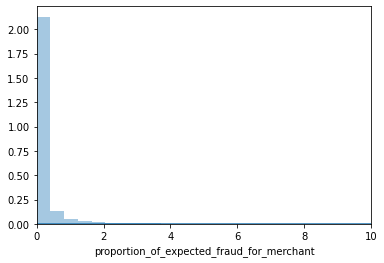

In [117]:
sns.distplot(df_new['proportion_of_expected_fraud_for_merchant'], bins=10000)
plt.xlim(0, 10)

Now run the same but with the extra column

In [118]:
df_new.head()

step     customer  age     merchant           category  amount  fraud  \
0     0  C1093826151    4   M348934600  es_transportation   4.550      0   
1     0   C352968107    2   M348934600  es_transportation  39.680      0   
2     0  C2054744914    4  M1823072687  es_transportation  26.890      0   
3     0  C1760612790    3   M348934600  es_transportation  17.250      0   
4     0   C757503768    5   M348934600  es_transportation  35.720      0   

   male  female  entity  proportion_of_expected_fraud_for_merchant  
0     1       0       0                                      0.356  
1     1       0       0                                      0.041  
2     0       1       0                                      0.060  
3     1       0       0                                      0.094  
4     1       0       0                                      0.045

### Categoy increase factor

Need to somehow get a factor for every category

In [119]:
category_mean_nonfraud_spends = df_nonfraud.groupby('category', as_index=False)['amount'].agg('mean')
category_mean_nonfraud_spends.columns = ['category', 'non_fraud_mean']
category_mean_nonfraud_spends.head()

category  non_fraud_mean
0  es_barsandrestaurants          41.170
1            es_contents          44.507
2             es_fashion          62.304
3                es_food          37.073
4              es_health         103.756

In [120]:
category_mean_fraud_spends = df_fraud.groupby('category', as_index=False)['amount'].agg('mean')
category_mean_fraud_spends.columns = ['category', 'fraud_mean']
category_mean_fraud_spends.head()

category  fraud_mean
0  es_barsandrestaurants     164.093
1             es_fashion     245.961
2              es_health     406.328
3                es_home     457.485
4       es_hotelservices     421.823

The sample merchants match the normal merchants

In [121]:
len(df_fraud['category'].unique())

12

In [122]:
len(df_nonfraud['category'].unique())

15

In [123]:
len(category_mean_fraud_spends['category'].unique())

12

In [124]:
len(category_mean_nonfraud_spends['category'].unique())

15

In [125]:
fraud_increase_df_cat = pd.merge(category_mean_nonfraud_spends, category_mean_fraud_spends, on='category', how='outer')
fraud_increase_df_cat['category_fraud_increase_factor'] = fraud_increase_df_cat['fraud_mean'] / fraud_increase_df_cat['non_fraud_mean']
fraud_increase_df_cat.drop('non_fraud_mean', axis=1, inplace=True)

# for some merchants there is no information on fraudulent transactions, so inputting that the level of fraud is the mean increase
# for all transactions
fraud_increase_df_cat['category_fraud_increase_factor'].fillna(np.mean(df_fraud['amount']) / np.mean(df_nonfraud['amount']), inplace=True)



fraud_increase_df_cat.head()

category  fraud_mean  category_fraud_increase_factor
0  es_barsandrestaurants     164.093                           3.986
1            es_contents         nan                          16.648
2             es_fashion     245.961                           3.948
3                es_food         nan                          16.648
4              es_health     406.328                           3.916

There are still some values missing, since fraud doesn't cover all categories  
We can just substitute in the average increase in the fraud amount here as a multiplier, and multiply the mean amount from the merchant by that factor to get an estimate of what the fraud increase factor would have been

In [126]:
approximate_fraud_values_cat = []
missing_categories = fraud_increase_df_cat[fraud_increase_df_cat.isna().any(axis=1)]['category'].tolist()
for i in range(len(missing_categories)):
    approximate_fraud_values_cat.append(df.groupby('category')['amount'].agg('mean').loc[missing_categories[i],])

In [127]:
missing_categories_df = pd.DataFrame(data={"category":missing_categories, "approximate_fraud_mean":approximate_fraud_values_cat})
missing_categories_df.head()

category  approximate_fraud_mean
0        es_contents                  44.507
1            es_food                  37.073
2  es_transportation                  26.955

In [128]:
# function selects the expected mean for the category if it is available, otherwise it selects the mean over all categories

def choose_mean(dataframe):
    if np.isnan(dataframe['fraud_mean']):
        return(dataframe['approximate_fraud_mean'])
    else:
        return(dataframe['fraud_mean'])

fraud_increase_df_cat = pd.merge(fraud_increase_df_cat, missing_categories_df, how='outer', on='category')
fraud_increase_df_cat['fraud_mean_complete'] = fraud_increase_df_cat.apply(choose_mean, axis=1)
fraud_increase_df_cat.drop(['approximate_fraud_mean', 'fraud_mean'], axis=1, inplace=True)
fraud_increase_df_cat.rename({'fraud_mean_complete': 'fraud_mean'}, axis=1, inplace=True)
fraud_increase_df_cat.head()
fraud_increase_df_cat

category  category_fraud_increase_factor  fraud_mean
0   es_barsandrestaurants                           3.986     164.093
1             es_contents                          16.648      44.507
2              es_fashion                           3.948     245.961
3                 es_food                          16.648      37.073
4               es_health                           3.916     406.328
5                 es_home                           4.041     457.485
6        es_hotelservices                           3.962     421.823
7                es_hyper                           4.231     169.255
8              es_leisure                           4.102     300.372
9        es_otherservices                           4.164     316.470
10       es_sportsandtoys                           3.903     345.647
11                es_tech                           4.236     422.578
12      es_transportation                          16.648      26.955
13              es_travel                           3.980    2662.529
14   es_wellnessandbeauty                           3.980     228.085

### Adding columns to Split Data - Category

In [129]:
df_new = pd.merge(df_new, fraud_increase_df_cat, on='category', how='left')

In [130]:
len(df_new)

591746

In [131]:
df_new['category_actual_increase_factor'] = df_new['fraud_mean'] / df_new['amount']

In [132]:
df_new['proportion_of_expected_fraud_for_category'] = df_new['category_actual_increase_factor'] / df_new['category_fraud_increase_factor']

In [133]:
df_new.drop(['fraud_mean', 'category_fraud_increase_factor', 'category_actual_increase_factor'], axis=1, inplace=True)

In [134]:
df_new.head()

step     customer  age     merchant           category  amount  fraud  \
0     0  C1093826151    4   M348934600  es_transportation   4.550      0   
1     0   C352968107    2   M348934600  es_transportation  39.680      0   
2     0  C2054744914    4  M1823072687  es_transportation  26.890      0   
3     0  C1760612790    3   M348934600  es_transportation  17.250      0   
4     0   C757503768    5   M348934600  es_transportation  35.720      0   

   male  female  entity  proportion_of_expected_fraud_for_merchant  \
0     1       0       0                                      0.356   
1     1       0       0                                      0.041   
2     0       1       0                                      0.060   
3     1       0       0                                      0.094   
4     1       0       0                                      0.045   

   proportion_of_expected_fraud_for_category  
0                                      0.356  
1                                      0.041  
2                                      0.060  
3                                      0.094  
4                                      0.045

In [135]:
df_new['proportion_of_expected_fraud_for_merchant'] == df_new['proportion_of_expected_fraud_for_category']

0         False
1         False
2         False
3         False
4         False
5         False
6         False
7         False
8         False
9         False
10        False
11        False
12        False
13        False
14        False
15        False
16        False
17        False
18        False
19        False
20        False
21        False
22        False
23        False
24        False
25        False
26        False
27        False
28        False
29        False
          ...  
591716    False
591717    False
591718    False
591719    False
591720    False
591721     True
591722    False
591723    False
591724    False
591725    False
591726    False
591727    False
591728    False
591729    False
591730    False
591731    False
591732    False
591733     True
591734    False
591735    False
591736    False
591737    False
591738    False
591739    False
591740    False
591741    False
591742    False
591743    False
591744    False
591745    False
Length: 591746, dtype: b

In [136]:
# fixing the zero error for amounts that are zero resulting in infinite value
df_new.loc[df_new['proportion_of_expected_fraud_for_category'] == np.inf, 'proportion_of_expected_fraud_for_category'] = 0

The new features can replace the now redundant merchant and category features

In [137]:
df_new.drop(['category', 'merchant'], axis=1, inplace=True)

Now processing again for regular and pca dataframes

In [138]:
df_processed_new = df_new.copy()

df_processed_new.drop('customer', axis=1, inplace=True)

Creating a seperate PCA dataframe

In [139]:
x_pca_new = df_processed_new.drop('fraud', axis=1).values

y_pca_new = df_processed_new['fraud'].values
# Standardizing the features
x_pca_new = StandardScaler().fit_transform(x_pca_new)

pca_2_new = PCA(n_components=3)
principalComponents_2 = pca_2_new.fit_transform(x_pca_new)
principalDf_2 = pd.DataFrame(data = principalComponents_2, columns = ['pc_1', 'pc_2','pc_3'])

df_pca_new = pd.concat([principalDf_2, df_new[['fraud']]], axis = 1)

splitting into training a testing data for regular and pca data

In [141]:
X_new = df_processed_new.drop('fraud',axis=1)
y_new = df_processed_new['fraud']

folds = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in folds.split(df_processed_new, df_processed_new['fraud']):
    X_strat_train_set_new, X_strat_test_set_new = X_new.loc[train_index], X_new.loc[test_index]
    y_strat_train_set_new, y_strat_test_set_new = y_new.loc[train_index], y_new.loc[test_index]
    
print("number of transactions in training data:", len(y_strat_train_set_new))
print("number of transactions in testing data:", len(y_strat_test_set_new))    
    
print("number of fraudulent transacitons in training data:", len(y_strat_train_set_new[y_strat_train_set_new == 1]))
print("number of fraudulent transacitons in testing data:", len(y_strat_test_set_new[y_strat_test_set_new == 1]))
    
print("proportion of fraudulent transacitons in training data:", round(len(y_strat_train_set_new[y_strat_train_set_new == 1])/len(y_strat_train_set_new), 3))
print("proportion of fraudulent transacitons in testing data:", round(len(y_strat_test_set_new[y_strat_test_set_new == 1])/len(y_strat_test_set_new), 3))
    

X_pca_new = df_pca_new.drop('fraud',axis=1)
y_pca_new = df_pca_new['fraud']

folds = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in folds.split(df_pca_new, df_pca_new['fraud']):
    X_strat_train_set_pca_new, X_strat_test_set_pca_new = X_pca_new.loc[train_index], X_pca_new.loc[test_index]
    y_strat_train_set_pca_new, y_strat_test_set_pca_new = y_pca_new.loc[train_index], y_pca_new.loc[test_index]
    
print("number of transactions in PCA training data:", len(y_strat_train_set_pca_new))
print("number of transactions in PCA testing data:", len(y_strat_test_set_pca_new))    
    
print("number of fraudulent transacitons in PCA training data:", len(y_strat_train_set_pca_new[y_strat_train_set_pca_new == 1]))
print("number of fraudulent transacitons in PCA testing data:", len(y_strat_test_set_pca_new[y_strat_test_set_pca_new == 1]))
    
print("proportion of fraudulent transacitons in PCA training data:", round(len(y_strat_train_set_pca_new[y_strat_train_set_pca_new == 1])/len(y_strat_train_set_pca_new), 3))
print("proportion of fraudulent transacitons in PCA testing data:", round(len(y_strat_test_set_pca_new[y_strat_test_set_pca_new == 1])/len(y_strat_test_set_pca_new), 3))
    



number of transactions in training data: 473396
number of transactions in testing data: 118350
number of fraulent transacitons in training data: 5728
number of fraulent transacitons in testing data: 1432
proportion of fraulent transacitons in training data: 0.012
proportion of fraulent transacitons in testing data: 0.012
number of transactions in PCA training data: 473396
number of transactions in PCA testing data: 118350
number of fraulent transacitons in PCA training data: 5728
number of fraulent transacitons in PCA testing data: 1432
proportion of fraulent transacitons in PCA training data: 0.012
proportion of fraulent transacitons in PCA testing data: 0.012


Used the same random state, so should have the same train and test split for pca and non-pca data. The indices for train and test should be the same

Oversampling on the training data of the regular and PCA data

In [142]:
oversampled_df_new, X_train_new, y_train_new = oversample_fraud(X_strat_train_set_new, y_strat_train_set_new)
print("length of oversampled training data", len(oversampled_df_new))
X_test_new = X_strat_test_set_new.copy()
y_test_new = y_strat_test_set_new.copy()


oversampled_df_pca_new, X_train_pca_new, y_train_pca_new = oversample_fraud(X_strat_train_set_pca_new, y_strat_train_set_pca_new)
print("length of oversampled training data from PCA dataframe", len(oversampled_df_pca_new))
X_test_pca_new = X_strat_test_set_pca_new.copy()
y_test_pca_new = y_strat_test_set_pca_new.copy()

length of oversampled training data 935336
length of oversampled training data from PCA dataframe 935336


Now the training data (and the training data for the PCA dataframe) contains an equal number of fraudulent and non fraudulent transactions

### Modelling After Feature Engineering

**Random Forest**

**Decision tree**

True Negatives: 116523
False Negatives: 410
False Positives: 395
True Positives: 1022
Accuracy: 0.9931981411068863
Sensitivity: 0.721242060691602
Specificity: 0.9964937186251956


(0.9931981411068863,
 0.721242060691602,
 0.9964937186251956,
 DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                        max_depth=None, max_features=None, max_leaf_nodes=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, presort='deprecated',
                        random_state=None, splitter='best'))

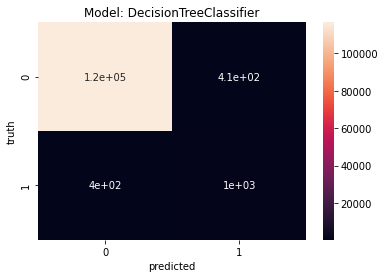

In [143]:
run_model(model = tree.DecisionTreeClassifier(criterion = "entropy"), X_train = X_train_new, y_train=y_train_new, X_test=X_test_new, y_test=y_test_new)

Random Forest

True Negatives: 116724
False Negatives: 463
False Positives: 194
True Positives: 969
Accuracy: 0.9944486692015209
Sensitivity: 0.8331900257953568
Specificity: 0.9960490498092792


(0.9944486692015209,
 0.8331900257953568,
 0.9960490498092792,
 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                        criterion='gini', max_depth=None, max_features='auto',
                        max_leaf_nodes=None, max_samples=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, n_estimators=20,
                        n_jobs=None, oob_score=False, random_state=None,
                        verbose=0, warm_start=False))

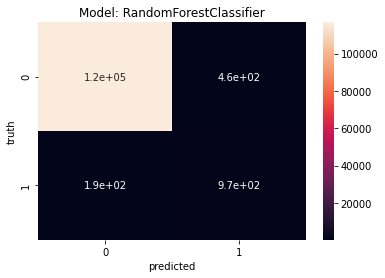

In [144]:
run_model(model = RandomForestClassifier(n_estimators=20), X_train = X_train_new, y_train=y_train_new, X_test=X_test_new, y_test=y_test_new)

Again scaling for the models that require it

In [145]:
X_train_scaled_new = StandardScaler().fit_transform(X_train_new.drop(['male', 'female', 'age','step'], axis=1))
X_test_scaled_new = StandardScaler().fit_transform(X_test_new.drop(['male', 'female', 'age', 'step'], axis=1))

# pca_data is already scaled


**SVM**

Note that training this is very slow. This will use only the first 100000 observations as the full dataset would be too computationally expensive

True Negatives: 831
False Negatives: 88
False Positives: 116087
True Positives: 1344
Accuracy: 0.018377693282636248
Sensitivity: 0.011445018776983932
Specificity: 0.9042437431991295


(0.018377693282636248,
 0.011445018776983932,
 0.9042437431991295,
 SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
     decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
     max_iter=-1, probability=False, random_state=None, shrinking=True,
     tol=0.001, verbose=False))

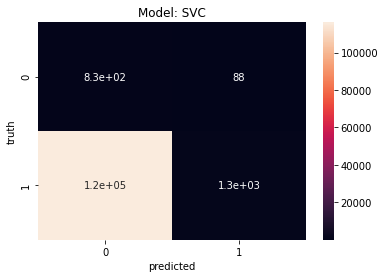

In [146]:
run_model(model = svm.SVC(), X_train = X_train_scaled_new[0:100000], y_train=y_train_new[0:100000], X_test=X_test_scaled_new, y_test=y_test_new)

**KNN**

True Negatives: 24784
False Negatives: 12
False Positives: 92134
True Positives: 1420
Accuracy: 0.22141106886354034
Sensitivity: 0.015178399640849135
Specificity: 0.9995160509759639


(0.22141106886354034,
 0.015178399640849135,
 0.9995160509759639,
 KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                      metric_params=None, n_jobs=None, n_neighbors=10, p=2,
                      weights='uniform'))

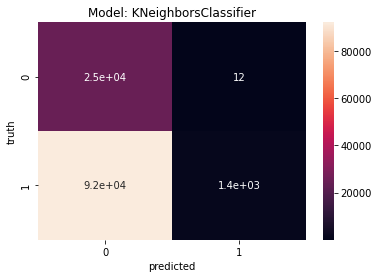

In [147]:
run_model(model = KNeighborsClassifier(n_neighbors=10), X_train = X_train_scaled_new, y_train=y_train_new, X_test=X_test_scaled_new, y_test=y_test_new)

**Neural Network**

Train on 935336 samples, validate on 118350 samples
Epoch 1/20
935336/935336 [==============================] - 8s 9us/step - loss: 0.1282 - accuracy: 0.9596 - val_loss: 5.3285 - val_accuracy: 0.0232
Epoch 2/20
935336/935336 [==============================] - 7s 8us/step - loss: 0.0735 - accuracy: 0.9722 - val_loss: 4.9427 - val_accuracy: 0.0304
Epoch 3/20
935336/935336 [==============================] - 8s 8us/step - loss: 0.0708 - accuracy: 0.9732 - val_loss: 5.0114 - val_accuracy: 0.0306
Epoch 4/20
935336/935336 [==============================] - 7s 8us/step - loss: 0.0695 - accuracy: 0.9735 - val_loss: 4.6428 - val_accuracy: 0.0301
Epoch 5/20
935336/935336 [==============================] - 8s 9us/step - loss: 0.0687 - accuracy: 0.9737 - val_loss: 4.8889 - val_accuracy: 0.0300
Epoch 6/20
935336/935336 [==============================] - 7s 8us/step - loss: 0.0683 - accuracy: 0.9737 - val_loss: 4.9521 - val_accuracy: 0.0298
Epoch 7/20
935336/935336 [==============================] - 

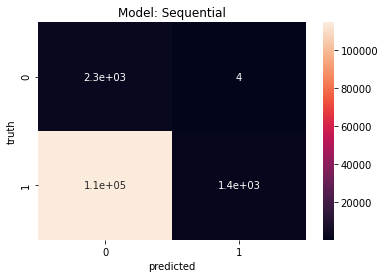

In [148]:
model = models.Sequential()
model.add(layers.Dense(10, activation='relu', input_shape=(X_train_scaled_new.shape[1],)))

model.add(layers.Dense(5, activation='relu'))

model.add(layers.Dense(3, activation='relu'))

model.add(layers.Dense(2, activation='softmax'))

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(X_train_scaled_new,
                    y_train_new,
                    validation_data = (X_test_scaled_new, y_test_new),
                    epochs=20,
                    batch_size=128)

y_predicted_nn_new = model.predict_classes(X_test_scaled_new)

cmx = confusion_matrix(y_predicted_nn_new, y_test_new)
sns.heatmap(cmx, annot=True)
plt.xlabel('predicted')
plt.ylabel('truth')
plt.title("Model: " + str(model.__class__.__name__));

TN = cmx[0,0]
FN = cmx[0,1]
FP = cmx[1,0]
TP = cmx[1,1]



print("True Negatives:", TN)
print("False Negatives:", FN)
print("False Positives:", FP)
print("True Positives:", TP)

print("Accuracy:", (TN + TP)/(TN + FN + FP + TP))
print("Sensitivity:", (TP)/(TP + FP))
print("Specificity:", (TN)/(TN + FN))

### Modelling on PCA Data

True Negatives: 116721
False Negatives: 644
False Positives: 197
True Positives: 788
Accuracy: 0.9928939585973806
Sensitivity: 0.8
Specificity: 0.9945128445447962


(0.9928939585973806,
 0.8,
 0.9945128445447962,
 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                        criterion='gini', max_depth=None, max_features='auto',
                        max_leaf_nodes=None, max_samples=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, n_estimators=20,
                        n_jobs=None, oob_score=False, random_state=None,
                        verbose=0, warm_start=False))

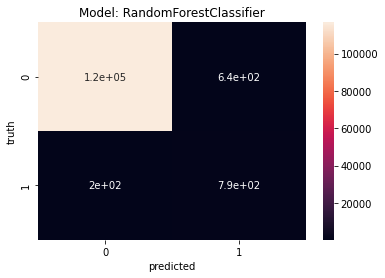

In [149]:
run_model(model = RandomForestClassifier(n_estimators=20),  X_train = X_train_pca_new, y_train=y_train_pca_new, X_test=X_test_pca_new, y_test=y_test_pca_new)

True Negatives: 116419
False Negatives: 644
False Positives: 499
True Positives: 788
Accuracy: 0.990342205323194
Sensitivity: 0.6122766122766122
Specificity: 0.9944986887402509


(0.990342205323194,
 0.6122766122766122,
 0.9944986887402509,
 DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                        max_depth=None, max_features=None, max_leaf_nodes=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, presort='deprecated',
                        random_state=None, splitter='best'))

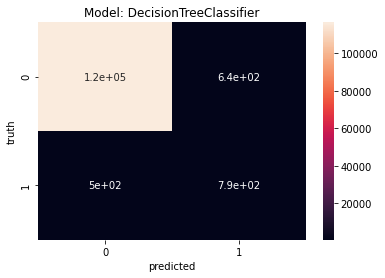

In [150]:
run_model(model = tree.DecisionTreeClassifier(criterion = "entropy"),  X_train = X_train_pca_new, y_train=y_train_pca_new, X_test=X_test_pca_new, y_test=y_test_pca_new)

True Negatives: 115558
False Negatives: 563
False Positives: 1360
True Positives: 869
Accuracy: 0.9837515842839036
Sensitivity: 0.3898609241812472
Specificity: 0.995151609097407


(0.9837515842839036,
 0.3898609241812472,
 0.995151609097407,
 KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                      metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                      weights='uniform'))

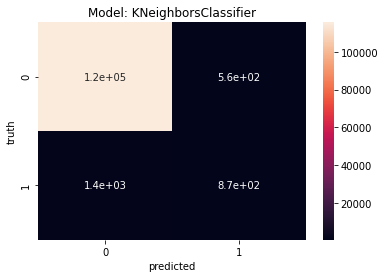

In [151]:
run_model(model = KNeighborsClassifier(n_neighbors=5), X_train = X_train_pca_new, y_train=y_train_pca_new, X_test=X_test_pca_new, y_test=y_test_pca_new)

### Grid Search

Random Forest has been identified as the best model. Grid search can now find the best combination of n_estimators and number of engineered features to use to obtain the optimal final model

In [153]:
# function to iterate through datasets and n_estimators, return a dataset of the performance metrics for each combination

def grid_search():
    
    names = ["no_engineered_features", "new_engineered_category_feature", "new_engineered_merchant_feature", "with_both_engineered_features"]
    estimators = [1,5,10,15,20,25,30,50,100]
    data_list = []
    estimator_list = []
    accuracy_list = []
    specificity_list = []
    sensitivity_list = []

    for i in range(len(data_to_test)):
        
        training_data_x, training_data_y, testing_data_x, testing_data_y = data_to_test[i]

        for j in range(len(estimators)):
            rf_model_iteration = RandomForestClassifier(n_estimators=estimators[j])
            rf_model_iteration.fit(training_data_x, training_data_y)

            y_predicted_iteration = rf_model_iteration.predict(testing_data_x)
            cmx = confusion_matrix(y_predicted_iteration, testing_data_y)

            TN = cmx[0,0]
            FN = cmx[0,1]
            FP = cmx[1,0]
            TP = cmx[1,1]

            sensitivity = (TP)/(TP + FP)
            specificity = (TN)/(TN + FN)

            accuracy_list.append(rf_model_iteration.score(testing_data_x, testing_data_y))
            sensitivity_list.append(sensitivity)
            specificity_list.append(specificity)
            data_list.append(names[i])
            estimator_list.append(estimators[j])
            

    results_df = pd.DataFrame(data={'data': data_list, 'n_estimators': estimator_list, 'accuracy':accuracy_list, 'sensitivity':sensitivity_list, 'specificity':specificity_list})
    results_df = results_df.sort_values('sensitivity', ascending=False)
    return(results_df)

In [154]:
# defining datasets to try in the grid search
no_engineered_features = [X_train, y_train, X_test, y_test]
new_engineered_category_feature = [X_train_new.drop('proportion_of_expected_fraud_for_merchant', axis=1), y_train_new, X_test_new.drop('proportion_of_expected_fraud_for_merchant', axis=1), y_test_new]
new_engineered_merchant_feature = [X_train_new.drop('proportion_of_expected_fraud_for_category', axis=1), y_train_new, X_test_new.drop('proportion_of_expected_fraud_for_category', axis=1), y_test_new]
with_engineered_features = [X_train_new, y_train_new, X_test_new, y_test_new]

data_to_test = [no_engineered_features, new_engineered_category_feature, new_engineered_merchant_feature, with_engineered_features]

In [162]:
grid_search_results = grid_search()
grid_search_results

data  n_estimators  accuracy  sensitivity  \
6            no_engineered_features            30     0.995        0.843   
8            no_engineered_features           100     0.995        0.840   
34    with_both_engineered_features            50     0.995        0.840   
7            no_engineered_features            50     0.995        0.840   
4            no_engineered_features            20     0.995        0.838   
2            no_engineered_features            10     0.995        0.838   
35    with_both_engineered_features           100     0.995        0.837   
5            no_engineered_features            25     0.995        0.834   
20  new_engineered_merchant_feature            10     0.994        0.831   
31    with_both_engineered_features            20     0.995        0.830   
29    with_both_engineered_features            10     0.994        0.826   
33    with_both_engineered_features            30     0.994        0.824   
32    with_both_engineered_features            25     0.994        0.821   
25  new_engineered_merchant_feature            50     0.994        0.820   
26  new_engineered_merchant_feature           100     0.994        0.819   
17  new_engineered_category_feature           100     0.994        0.818   
3            no_engineered_features            15     0.995        0.816   
22  new_engineered_merchant_feature            20     0.994        0.814   
24  new_engineered_merchant_feature            30     0.994        0.813   
16  new_engineered_category_feature            50     0.994        0.811   
13  new_engineered_category_feature            20     0.994        0.810   
23  new_engineered_merchant_feature            25     0.994        0.806   
11  new_engineered_category_feature            10     0.994        0.806   
30    with_both_engineered_features            15     0.994        0.805   
15  new_engineered_category_feature            30     0.994        0.801   
1            no_engineered_features             5     0.995        0.800   
21  new_engineered_merchant_feature            15     0.994        0.796   
12  new_engineered_category_feature            15     0.993        0.790   
14  new_engineered_category_feature            25     0.993        0.788   
19  new_engineered_merchant_feature             5     0.994        0.767   
28    with_both_engineered_features             5     0.994        0.759   
10  new_engineered_category_feature             5     0.993        0.731   
0            no_engineered_features             1     0.993        0.698   
27    with_both_engineered_features             1     0.992        0.667   
18  new_engineered_merchant_feature             1     0.992        0.660   
9   new_engineered_category_feature             1     0.990        0.586   

    specificity  
6         0.997  
8         0.997  
34        0.996  
7         0.997  
4         0.997  
2         0.997  
35        0.996  
5         0.997  
20        0.996  
31        0.996  
29        0.996  
33        0.996  
32        0.996  
25        0.996  
26        0.996  
17        0.995  
3         0.997  
22        0.996  
24        0.996  
16        0.995  
13        0.995  
23        0.996  
11        0.995  
30        0.996  
15        0.995  
1         0.997  
21        0.996  
12        0.995  
14        0.995  
19        0.996  
28        0.996  
10        0.996  
0         0.997  
27        0.997  
18        0.996  
9         0.996

### Best Performing Model

The best model is the Random Forest with both engineered features, after dropping merchant and category columns should not have been used as label encoders

True Negatives: 116712
False Negatives: 454
False Positives: 206
True Positives: 978
Accuracy: 0.9944233206590621
Sensitivity: 0.8260135135135135
Specificity: 0.9961251557619104


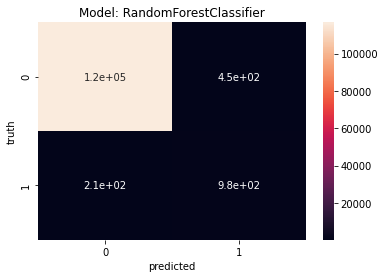

In [156]:
best_model_results = run_model(model = RandomForestClassifier(n_estimators=30),  X_train = X_train_new, y_train=y_train_new, X_test=X_test_new, y_test=y_test_new)
best_model = best_model_results[3]

### Visualising Models

Individual decision trees on the same data can be run to show how decision trees would vote in the random forest

Decision tree with low depth for easier visualisation

See how category and amount  are the first splits  
The tree does a good job of classifying, despite the inherent drawback of it assuming some order to the category code and merchant code features, when the label encoder results are arbitrary for those variables

0.9475200675961132


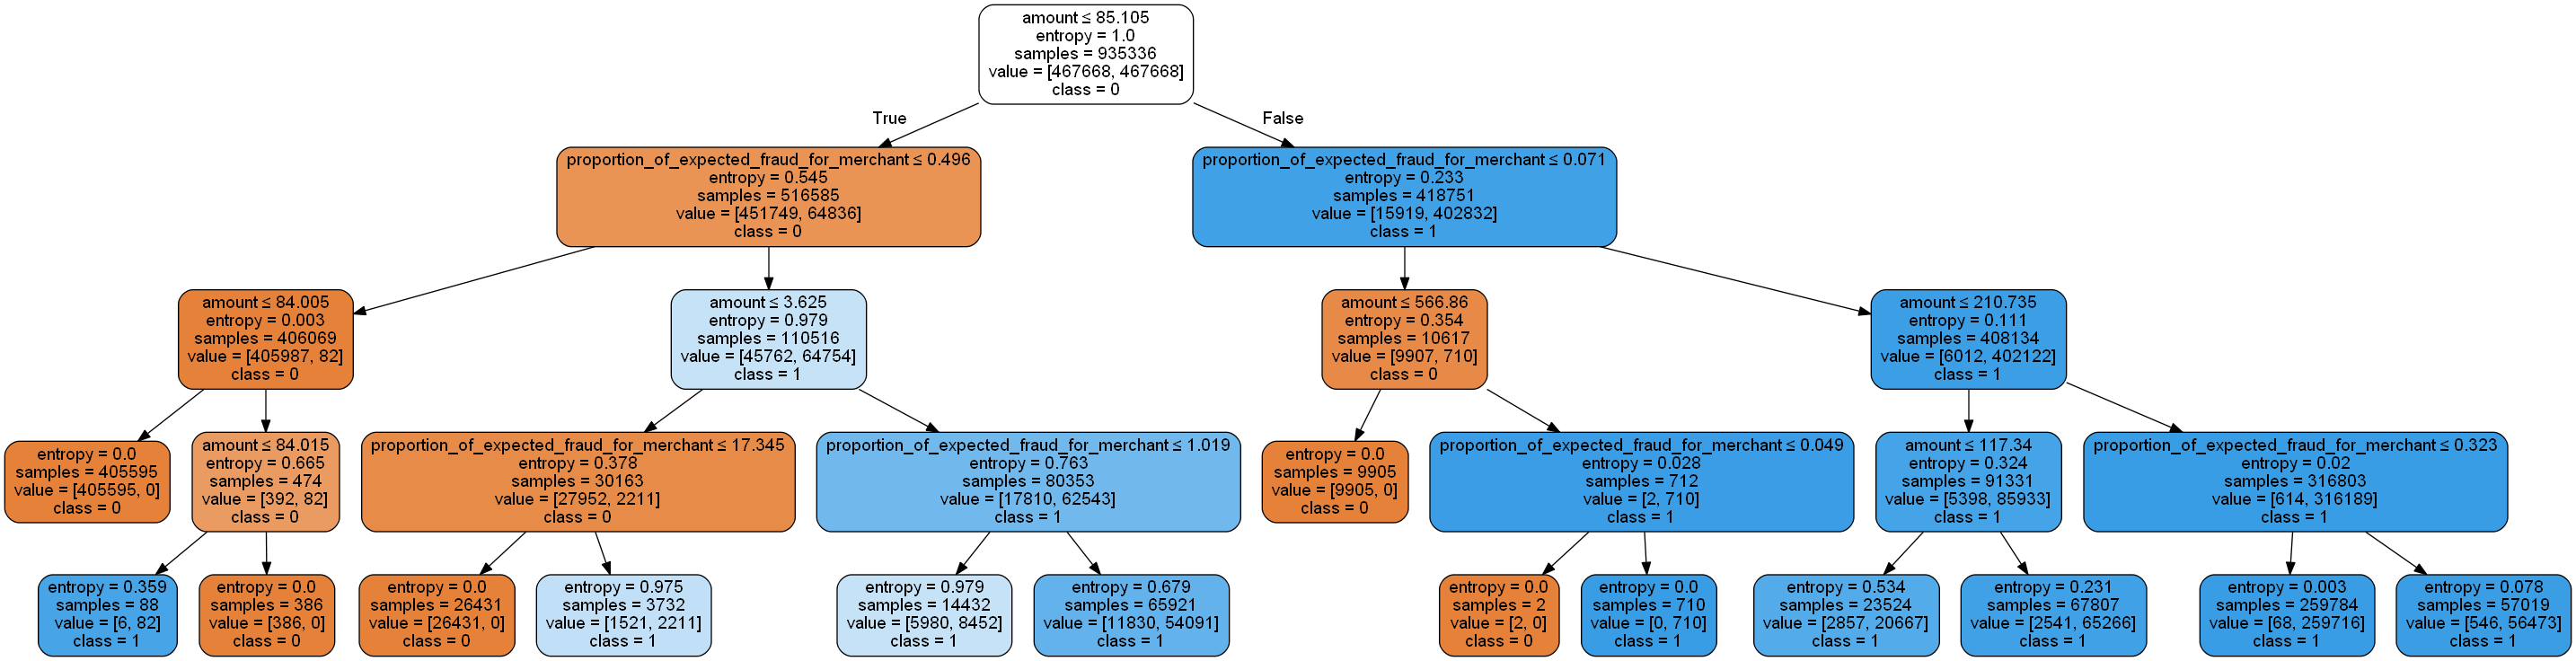

In [157]:
single_tree_model = tree.DecisionTreeClassifier(criterion = "entropy", max_depth=4)
single_tree_model.fit(X_train_new, y_train_new)

print(single_tree_model.score(X_test_new, y_test_new))

dot_data = StringIO()
tree.export_graphviz(single_tree_model, 
 out_file=dot_data, 
 class_names=['0', '1'], # the target names.
 feature_names=X_train_new.columns, # the feature names.
 filled=True, # Whether to fill in the boxes with colours.
 rounded=True, # Whether to round the corners of the boxes.
 special_characters=True)
(graph,) = pydot.graph_from_dot_data(dot_data.getvalue())

# graph = pydotplus.graph_from_dot_data(dot_data.getvalue()) 
# print(graph)
Image(graph.create_png())

Can see a much deeper tree if neccessary however, just by ammending the max depth parameter

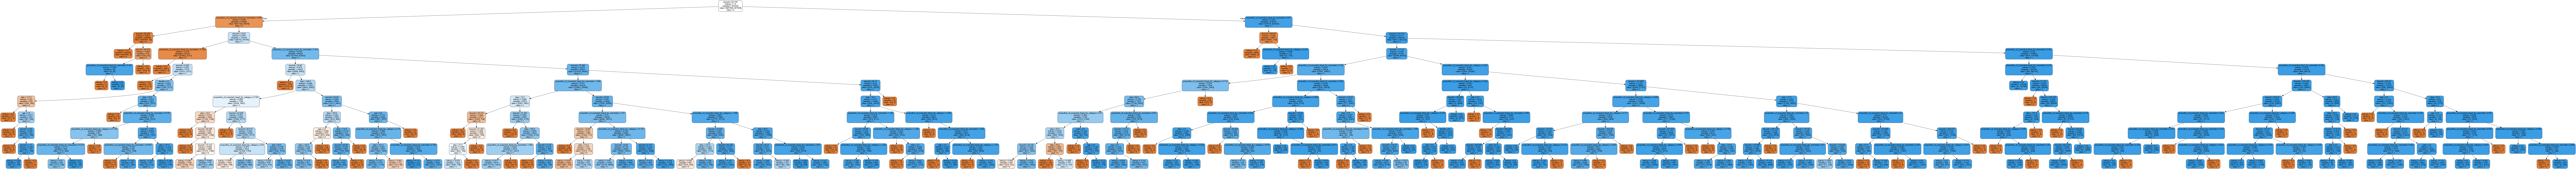

In [158]:
single_tree_model = tree.DecisionTreeClassifier(criterion = "entropy", max_depth = 10)
single_tree_model.fit(X_train_new, y_train_new)

dot_data = StringIO()
tree.export_graphviz(single_tree_model, 
 out_file=dot_data, 
 class_names=['0', '1'], # the target names.
 feature_names=X_train_new.columns, # the feature names.
 filled=True, # Whether to fill in the boxes with colours.
 rounded=True, # Whether to round the corners of the boxes.
 special_characters=True)
(graph,) = pydot.graph_from_dot_data(dot_data.getvalue())

# graph = pydotplus.graph_from_dot_data(dot_data.getvalue()) 
# print(graph)
Image(graph.create_png())

Check the feature importance of the best performing model - random forest

amount                                      0.541
proportion_of_expected_fraud_for_merchant   0.232
proportion_of_expected_fraud_for_category   0.197
step                                        0.019
age                                         0.006
female                                      0.003
male                                        0.003
entity                                      0.000
dtype: float64


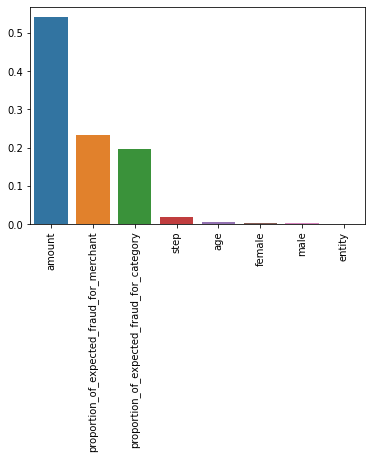

In [166]:
feature_imp = pd.Series(best_model.feature_importances_, index=X_train_new.columns).sort_values(ascending=False)
print(feature_imp)
sns.barplot(x=feature_imp.index, y=feature_imp);
plt.xticks(rotation=90);